# Lab: Regularizing MLPs

------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this lab, you'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

**Participants:**
* Piero Paolo Rivera Ramírez (100435291)
* Paula Marcela Mora Caballero (100483694)

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping and dropout.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [11]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Lets take a look to the mini-batch size and plot a sample.

In [12]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

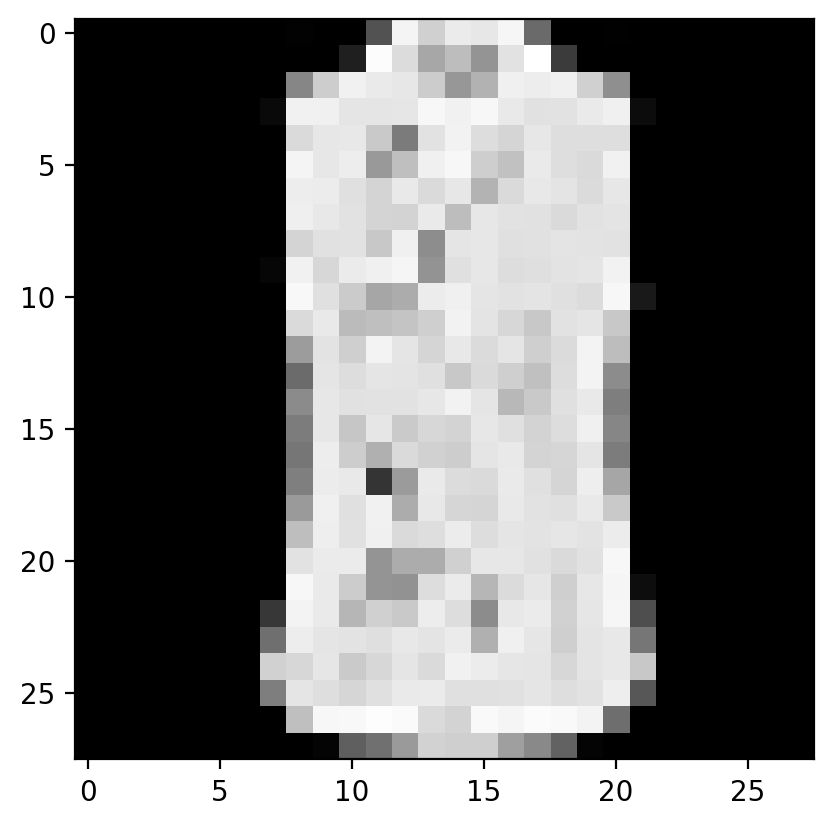

In [13]:
plt.imshow(images[7].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and evaluate train/test performance

In [14]:
class MLP(nn.Module):
  
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels):
        super().__init__()
        self.output1 = nn.Linear(dimx, hidden1)
        self.output2 = nn.Linear(hidden1, hidden2)
        self.output3 = nn.Linear(hidden2, hidden3)
        self.output4 = nn.Linear(hidden3, nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [15]:
class MLP_extended(MLP):
    
    #YOUR CODE HERE
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, epochs=30, lr=0.001):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
    
    def accuracy_rate(self, loader):
        accuracy = 0
        
        with torch.no_grad():
            
            for images, labels in loader:
                logprobs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
            accuracy_rate = accuracy/len(loader)

        return accuracy_rate
    
    
    def trainloop(self, loader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            test_iter=True
            
            for images, labels in loader:
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                if test_iter:
                   print(images.shape)
                   print(images.view(images.shape[0], -1).shape)
                   test_iter=False
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                
            self.loss_during_training.append(running_loss/len(loader))

            if(e % 1 == 0): # Every 10 epochs
                print("Training loss after %d epochs: %f"
                      %(e,self.loss_during_training[-1]))


In [16]:
#YOUR CODE HERE
my_MLP = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=2, lr=1e-3)
my_MLP.trainloop(trainloader)
print("Train Accuracy: %f" %my_MLP.accuracy_rate(trainloader))
print("Test Accuracy: %f" %my_MLP.accuracy_rate(testloader))

torch.Size([64, 1, 28, 28])
Training loss after 0 epochs: 0.518145
torch.Size([64, 1, 28, 28])
Training loss after 1 epochs: 0.380073
torch.Size([64, 1, 28, 28])
Training loss after 2 epochs: 0.339538
torch.Size([64, 1, 28, 28])
Training loss after 3 epochs: 0.315130
torch.Size([64, 1, 28, 28])
Training loss after 4 epochs: 0.296518
Train Accuracy: 0.898038
Test Accuracy: 0.873806


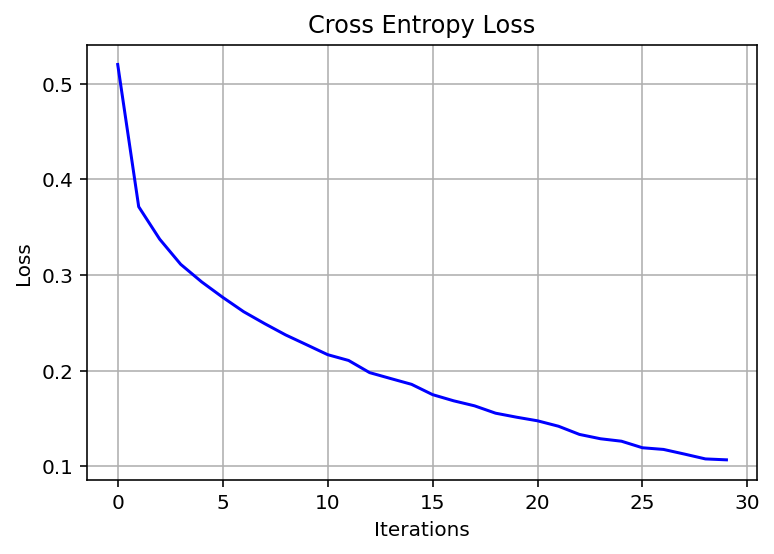

In [ ]:
plt.plot(my_MLP.loss_during_training, '-b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss')
plt.grid()

In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [ ]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]



> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs. Compute the final train/validation/test performance.

In [ ]:
#YOUR CODE HERE

class MLP_extended(MLP):
    
    #YOUR CODE HERE
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, epochs=30, lr=0.001):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.train_loss_during_training = []
        self.valid_loss_during_training = []
    
    def accuracy_rate(self, loader):
        accuracy = 0
        
        with torch.no_grad():
            
            for images, labels in loader:
                logprobs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
            accuracy_rate = accuracy/len(loader)

        return accuracy_rate
    
    
    def trainloop(self, trainloader, validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                
            self.train_loss_during_training.append(running_loss/len(trainloader))
            
            with torch.no_grad():
                running_loss = 0.
            
                for images, labels in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/len(validloader))

            if(e % 1 == 0): # Every 10 epochs
                print("Loss after %d epochs: Training: %f, Validation: %f"
                      %(e, self.train_loss_during_training[-1], self.valid_loss_during_training[-1]))

In [12]:
#YOUR CODE HERE
my_MLP = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=30, lr=1e-3)
my_MLP.trainloop(trainloader, validloader)

print("Train Accuracy: %f" %my_MLP.accuracy_rate(trainloader))
print("Validation Accuracy: %f" %my_MLP.accuracy_rate(validloader))
print("Test Accuracy: %f" %my_MLP.accuracy_rate(testloader))

Loss after 0 epochs: Training: 0.545427, Validation: 0.431841
Loss after 1 epochs: Training: 0.389646, Validation: 0.386036
Loss after 2 epochs: Training: 0.349633, Validation: 0.353094
Loss after 3 epochs: Training: 0.323337, Validation: 0.345091
Loss after 4 epochs: Training: 0.302290, Validation: 0.354990
Loss after 5 epochs: Training: 0.287142, Validation: 0.346445
Loss after 6 epochs: Training: 0.269571, Validation: 0.327166
Loss after 7 epochs: Training: 0.255828, Validation: 0.349250
Loss after 8 epochs: Training: 0.244150, Validation: 0.338961
Loss after 9 epochs: Training: 0.227938, Validation: 0.354993
Loss after 10 epochs: Training: 0.222563, Validation: 0.350715
Loss after 11 epochs: Training: 0.213725, Validation: 0.328753
Loss after 12 epochs: Training: 0.204516, Validation: 0.348796
Loss after 13 epochs: Training: 0.194895, Validation: 0.353899
Loss after 14 epochs: Training: 0.187911, Validation: 0.333988
Loss after 15 epochs: Training: 0.176309, Validation: 0.334555
Lo

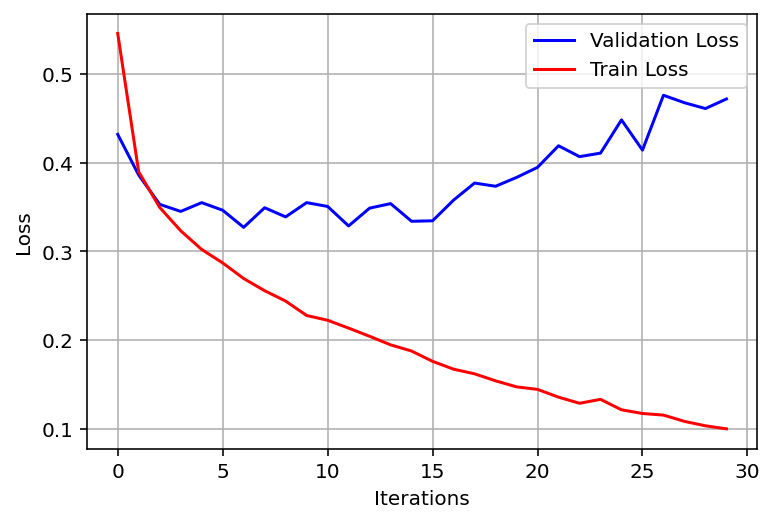

In [13]:
#YOUR CODE HERE
plt.plot(my_MLP.valid_loss_during_training, '-b', label='Validation Loss')
plt.plot(my_MLP.train_loss_during_training, '-r', label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

In [14]:
#YOUR CODE HERE
my_MLP_es = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=8, lr=1e-3)
my_MLP_es.trainloop(trainloader, validloader)
print("Train Accuracy: %f" %my_MLP_es.accuracy_rate(trainloader))
print("Validation Accuracy: %f" %my_MLP_es.accuracy_rate(validloader))
print("Test Accuracy: %f" %my_MLP_es.accuracy_rate(testloader))

Loss after 0 epochs: Training: 0.547265, Validation: 0.423078
Loss after 1 epochs: Training: 0.393009, Validation: 0.399758
Loss after 2 epochs: Training: 0.355392, Validation: 0.399553
Loss after 3 epochs: Training: 0.323923, Validation: 0.410494
Loss after 4 epochs: Training: 0.302558, Validation: 0.366639
Loss after 5 epochs: Training: 0.287617, Validation: 0.340529
Loss after 6 epochs: Training: 0.270876, Validation: 0.335518
Loss after 7 epochs: Training: 0.257875, Validation: 0.385131
Train Accuracy: 0.892689
Validation Accuracy: 0.866223
Test Accuracy: 0.859375


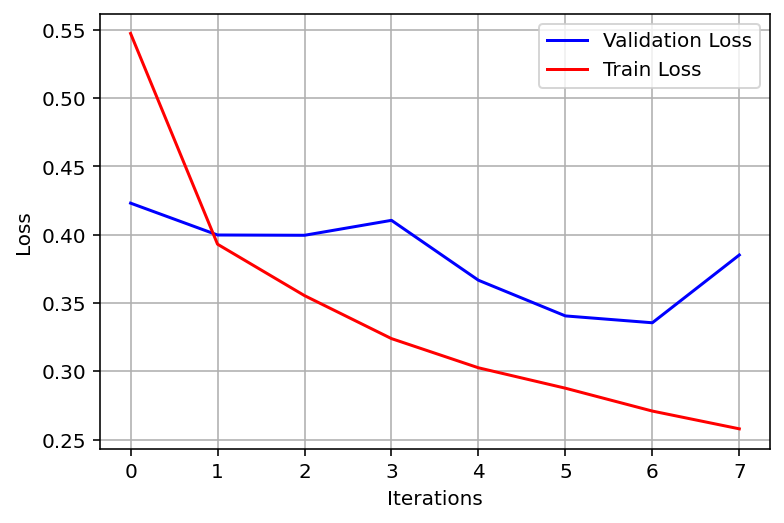

In [15]:
plt.plot(my_MLP_es.valid_loss_during_training, '-b', label='Validation Loss')
plt.plot(my_MLP_es.train_loss_during_training, '-r', label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modify the extended class to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [16]:
class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,p,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        self.output1 = nn.Linear(dimx,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)
        self.output4 = nn.Linear(hidden3,nlabels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [21]:
class MLPdrop_extended(MLPdrop):
    def __init__(self,dimx,hidden1,hidden2,hidden3,p,nlabels,epochs=100,lr=0.001):
        # We define some objects of the class. We need to use multiexpended
        super().__init__(dimx,hidden1,hidden2,hidden3,p, nlabels)  
        self.lr = lr 
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
                
    def trainloop(self,trainloader,validloader):
        # Optimization Loop
        for e in range(int(self.epochs)):
            running_loss = 0.
            for images, labels in trainloader: 
                self.train()
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                self.eval()
            self.loss_during_training.append(running_loss/len(trainloader))
            
            with torch.no_grad():                
                running_loss = 0.
                for images,labels in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out,labels)
                    running_loss += loss.item()   
                self.valid_loss_during_training.append(running_loss/len(validloader))    
            if(e % 1 == 0): 
                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))
                
    def accuracy_rate(self,loader):              
        loss = 0
        accuracy = 0
        with torch.no_grad():
            for images,labels in loader:
                logprobs = self.forward(images.view(images.shape[0], -1)) 
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        return accuracy/len(loader)

**Incorporation of a dropout step with p=0.2 after every ReLU non-linearity:**

In [22]:
#YOUR CODE HERE
# p = 0.2
my_MLP_dropout_p02 = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, p=0.2, nlabels=10, epochs=30, lr=1e-3)
my_MLP_dropout_p02.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.644561, Validation loss: 0.450955
Epoch 1. Training loss: 0.458166, Validation loss: 0.420409
Epoch 2. Training loss: 0.415153, Validation loss: 0.409911
Epoch 3. Training loss: 0.386276, Validation loss: 0.358008
Epoch 4. Training loss: 0.366500, Validation loss: 0.372485
Epoch 5. Training loss: 0.354813, Validation loss: 0.370547
Epoch 6. Training loss: 0.337470, Validation loss: 0.330001
Epoch 7. Training loss: 0.332459, Validation loss: 0.336580
Epoch 8. Training loss: 0.314998, Validation loss: 0.327919
Epoch 9. Training loss: 0.308066, Validation loss: 0.325389
Epoch 10. Training loss: 0.306189, Validation loss: 0.336728
Epoch 11. Training loss: 0.293935, Validation loss: 0.336004
Epoch 12. Training loss: 0.288116, Validation loss: 0.330405
Epoch 13. Training loss: 0.283106, Validation loss: 0.343724
Epoch 14. Training loss: 0.277513, Validation loss: 0.327505
Epoch 15. Training loss: 0.271248, Validation loss: 0.320020
Epoch 16. Training loss: 0.266555,

In [23]:
print("Train Accuracy: %f" %my_MLP_dropout_p02.accuracy_rate(trainloader))
print("Validation Accuracy: %f" %my_MLP_dropout_p02.accuracy_rate(validloader))
print("Test Accuracy: %f" %my_MLP_dropout_p02.accuracy_rate(testloader))

Train Accuracy: 0.935525
Validation Accuracy: 0.888785
Test Accuracy: 0.883758



On one hand, the train accuracy is significant lower that without it, 0.93 compared with 0.97 without it, but on the other hand, the validation and test accuracy remain almost the same. We can think that introducing a dropout rate p=0.2 does help to prevent the overfitting. 

With dropout, the validation loss stabilizes compared to the previous one and does not start to increase after soe iterations, which may indicate that early stopping is not requiered.


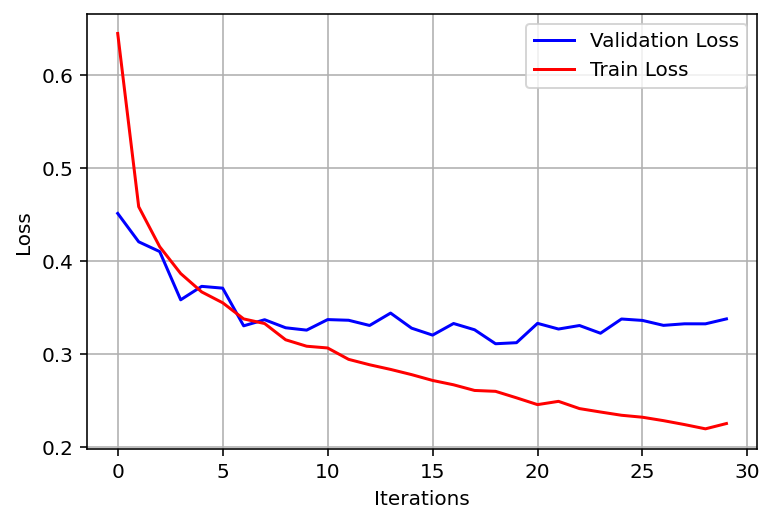

In [26]:
plt.plot(my_MLP_dropout_p02.valid_loss_during_training, '-b', label='Validation Loss')
plt.plot(my_MLP_dropout_p02.loss_during_training, '-r', label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

**Repetition of the experiments with a dropout probability of 0.2 and 0.3:**

In [29]:
#YOUR CODE HERE
# p = 0.1
my_MLP_dropout_p01 = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, p=0.1, nlabels=10, epochs=30, lr=1e-3)
my_MLP_dropout_p01.trainloop(trainloader, validloader)

# p = 0.3
my_MLP_dropout_p03 = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, p=0.3, nlabels=10, epochs=30, lr=1e-3)
my_MLP_dropout_p03.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.594710, Validation loss: 0.426548
Epoch 1. Training loss: 0.421699, Validation loss: 0.400146
Epoch 2. Training loss: 0.378385, Validation loss: 0.374043
Epoch 3. Training loss: 0.357197, Validation loss: 0.363293
Epoch 4. Training loss: 0.339442, Validation loss: 0.348527
Epoch 5. Training loss: 0.322908, Validation loss: 0.341307
Epoch 6. Training loss: 0.308147, Validation loss: 0.351736
Epoch 7. Training loss: 0.294106, Validation loss: 0.325835
Epoch 8. Training loss: 0.285026, Validation loss: 0.323884
Epoch 9. Training loss: 0.274799, Validation loss: 0.321146
Epoch 10. Training loss: 0.268067, Validation loss: 0.353483
Epoch 11. Training loss: 0.258914, Validation loss: 0.320373
Epoch 12. Training loss: 0.251349, Validation loss: 0.331934
Epoch 13. Training loss: 0.246546, Validation loss: 0.328655
Epoch 14. Training loss: 0.237645, Validation loss: 0.329629
Epoch 15. Training loss: 0.235876, Validation loss: 0.323488
Epoch 16. Training loss: 0.228666,

In [32]:
#YOUR CODE HERE
# p = 0.1
print("Train Accuracy: %f" %my_MLP_dropout_p01.accuracy_rate(trainloader))
print("Validation Accuracy: %f" %my_MLP_dropout_p01.accuracy_rate(validloader))
print("Test Accuracy: %f" %my_MLP_dropout_p01.accuracy_rate(testloader))

Train Accuracy: 0.951971
Validation Accuracy: 0.894947
Test Accuracy: 0.885350


In [33]:
#YOUR CODE HERE
# p = 0.3
print("Train Accuracy: %f" %my_MLP_dropout_p03.accuracy_rate(trainloader))
print("Validation Accuracy: %f" %my_MLP_dropout_p03.accuracy_rate(validloader))
print("Test Accuracy: %f" %my_MLP_dropout_p03.accuracy_rate(testloader))

Train Accuracy: 0.924228
Validation Accuracy: 0.886503
Test Accuracy: 0.884057


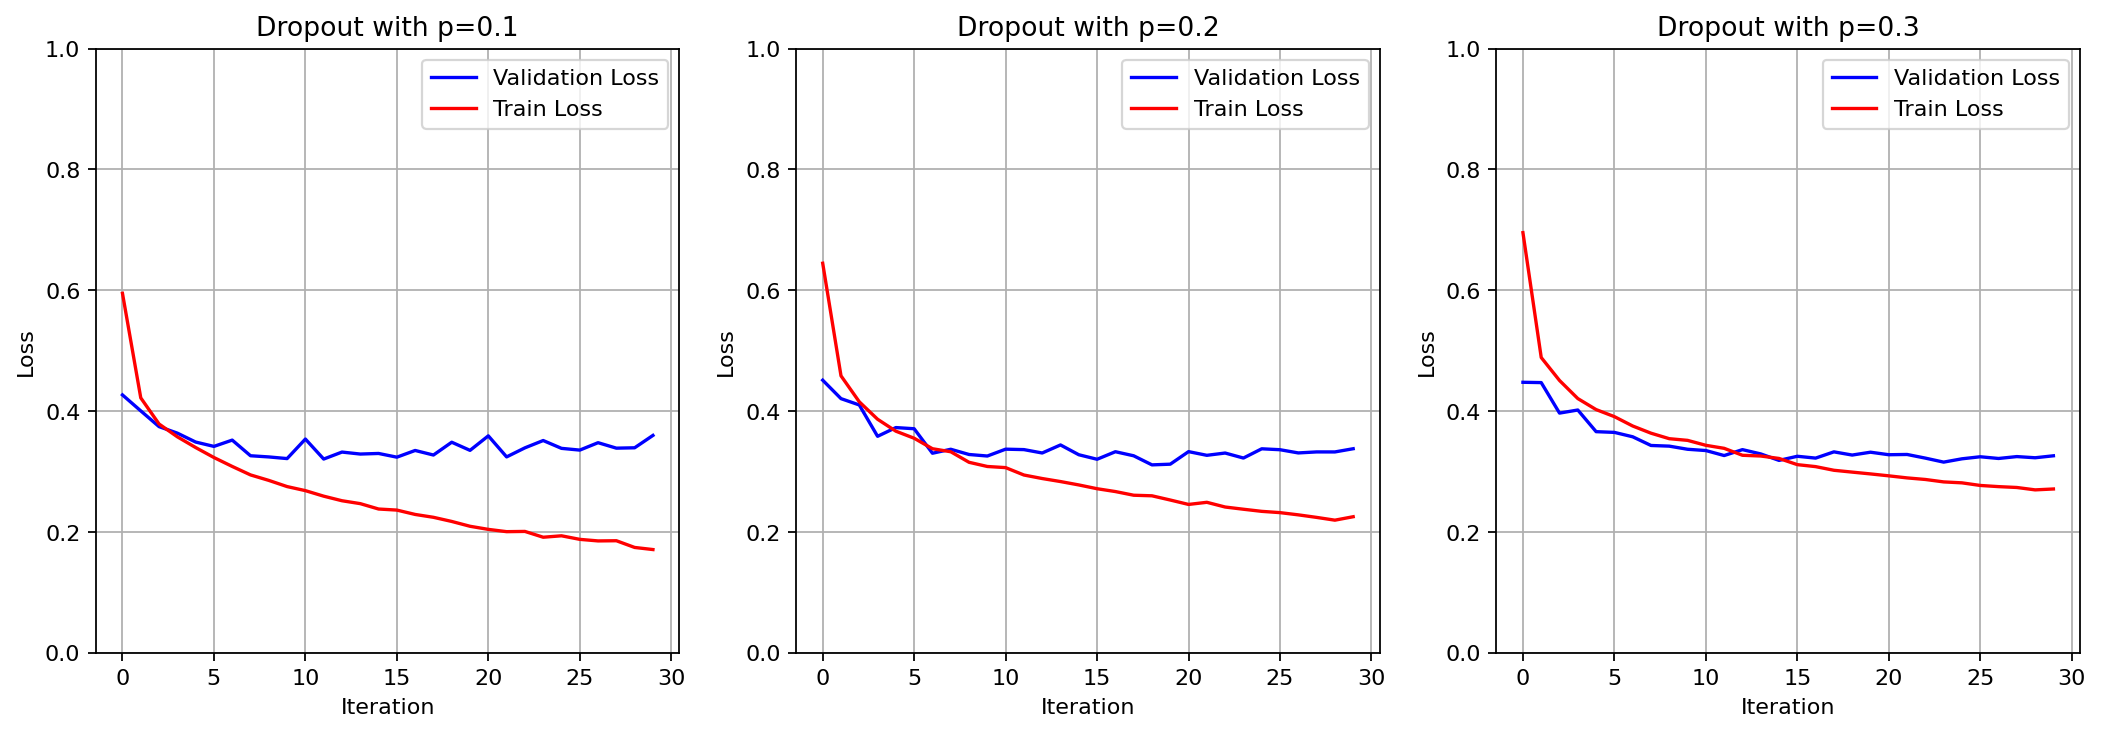

In [35]:
#YOUR CODE HERE
#Comparison
models = [my_MLP_dropout_p01, my_MLP_dropout_p02, my_MLP_dropout_p03]
dropout_rates = [0.1, 0.2, 0.3]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=80)

for i, ax in enumerate(axes):
    model = models[i]
    dropout_rate = dropout_rates[i]
    ax.plot(model.valid_loss_during_training, '-b', label='Validation Loss')
    ax.plot(model.loss_during_training, '-r', label='Train Loss')
    ax.legend()
    ax.set_title(f'Dropout with p={dropout_rate}')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iteration')
    ax.grid()
    ax.set_ylim([0, 1])

plt.show()

Based on validation accuracy values obtained, the value that provides the best validation accuracy is with p=0.1 (0.894947). Althought, there is no significant increase in the validation accuracy compared with p=0.2 (0.888785) and p=0.3 (0.886503). Also, we notice that a higher drop out rate results in lower accuracy training rates.

Based on the loss performance across the 30 iterations, the best validation performance is for p=0.3, where we see a more stable validation loss. It's important to notice that increasing the dropout rate may lead to underfitting, which we can notice in the train loss getting higher for higher values of p.